In [1]:
%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["figure.dpi"] = 150

import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pathlib

# DS imports
import pandas as pd

# Custom imports
from atomichackpy import utils

In [3]:
DATA_DIR = pathlib.Path("../data/dataset")

In [4]:
RS = 23789465

In [5]:
%load_ext autoreload
%autoreload 2

# Загрузка разметки

In [108]:
frames = pd.read_csv(DATA_DIR.joinpath("frames.csv"))
train_target = pd.read_csv(DATA_DIR.joinpath("train_defect_target_clean.csv"))
test_target = pd.read_csv(DATA_DIR.joinpath("test_defect_target_clean.csv"))
classes = pd.read_csv(DATA_DIR.joinpath("metadata", "classes.csv"))

На предыдущем шаге забыли поправить имена файлов (с Windows на Linux):

In [109]:
test_target["frame"] = test_target["frame"].apply(lambda v: pathlib.PureWindowsPath(v).as_posix())

## Проверка баланса классов и наличия всех классов в тренировочном и тестовом множествах

In [110]:
train_target.merge(classes, left_on="label", right_on="class").classname.value_counts()

classname
не дефект           21564
потертость           3823
н.д. микровыступ      820
микровыступ           448
Name: count, dtype: int64

In [111]:
test_target.merge(classes, left_on="label", right_on="class").classname.value_counts()

classname
не дефект             2408
грязь                 1343
маркер                1072
потертость             428
мех.повреждение        325
черная точка           284
накол                  254
плена                  219
н.д. накол             162
царапина с волчком     153
н.д. микровыступ        99
риска                   67
микровыступ             57
вмятина                 51
Name: count, dtype: int64

Таким образом, некоторые классы не встречаются в тренировочном множестве, поэтому набор придётся переразбить.

In [235]:
train_target["source"] = "train"
test_target["source"] = "test"
target = pd.concat([train_target, test_target], ignore_index=True)

In [236]:
target

,frame,x,y,label,source
0,0/1538/frame0006.frame,601,299,0,train
1,0/1538/frame0007.frame,445,300,0,train
2,0/1538/frame0007.frame,338,94,0,train
3,0/1538/frame0007.frame,863,271,0,train
4,0/1538/frame0009.frame,864,390,0,train
...,...,...,...,...,...
33572,2023.10.25/5_682.frame,568,448,0,test
33573,2023.10.25/5_874.frame,214,212,0,test
33574,2023.10.25/5_874.frame,509,389,0,test
33575,2023.10.25/5_882.frame,745,271,0,test


Проверим дубликаты:

In [237]:
target.duplicated(subset=["frame", "x", "y"]).value_counts()

False    33577
Name: count, dtype: int64

Убираем кадры, которых нет на диске:

In [238]:
target = target[target.frame.isin(frames.frame)]

Разбиваем на тренировочное и тестовое множества по кадрам (т. е. все дефекты одного кадра отправляются в одно из множеств). Уникальных кадров, для которых есть разметка:

In [239]:
target.frame.nunique()

6841

Перемешаем имена фреймов, а потом разделим на три части:

In [240]:
unique_frames = target.frame.unique()

np.random.seed(RS)
np.random.shuffle(unique_frames)
unique_frames

array(['2021.08.30/5/4_579.frame', '2023.07.12/4_486.frame',
       '2022.06.21/0/3_617.frame', ...,
       '2022.11.24/t29_dist_1_frame_1.frame', '2022.11.22/1_640.frame',
       '2022.12.08/3_661.frame'], dtype=object)

In [241]:
TRAIN_FRAMES = unique_frames[:3500]
VAL_FRAMES = unique_frames[3500:5500]
TEST_FRAMES = unique_frames[5500:]

Для надёжности проверяем пересечения:

In [242]:
np.intersect1d(TRAIN_FRAMES, VAL_FRAMES)

array([], dtype=object)

In [243]:
np.intersect1d(TEST_FRAMES, VAL_FRAMES)

array([], dtype=object)

In [244]:
np.intersect1d(TEST_FRAMES, TRAIN_FRAMES)

array([], dtype=object)

Проверяем баланс и представленность классов в множествах:

In [245]:
(target[target.frame.isin(TRAIN_FRAMES)]
 .merge(classes, left_on="label", right_on="class")
 .classname
 .value_counts())

classname
не дефект             12180
потертость             2201
грязь                   683
маркер                  591
н.д. микровыступ        454
микровыступ             261
черная точка            150
накол                   142
мех.повреждение         142
плена                   116
царапина с волчком       77
н.д. накол               76
риска                    33
вмятина                  26
Name: count, dtype: int64

In [246]:
(target[target.frame.isin(VAL_FRAMES)]
 .merge(classes, left_on="label", right_on="class")
 .classname
 .value_counts())

classname
не дефект             7130
потертость            1247
грязь                  408
маркер                 295
н.д. микровыступ       271
микровыступ            140
мех.повреждение        105
черная точка            87
накол                   68
плена                   67
н.д. накол              53
царапина с волчком      48
вмятина                 16
риска                   15
Name: count, dtype: int64

In [247]:
(target[target.frame.isin(TEST_FRAMES)]
 .merge(classes, left_on="label", right_on="class")
 .classname
 .value_counts())

classname
не дефект             4662
потертость             803
грязь                  252
н.д. микровыступ       194
маркер                 186
микровыступ            104
мех.повреждение         78
черная точка            47
накол                   44
плена                   36
н.д. накол              33
царапина с волчком      28
риска                   19
вмятина                  9
Name: count, dtype: int64

При таком разбиении мы можем тренировать модель на все классы, т. к. все они представлены в каждом из множеств.

# Принцип выборки данных из кадров

Исходя из того, как отмечены дефекты на кадрах, можно заключить следующее:

- разметка неполна, т. е. нельзя гарантировать, что отмечены **все** дефекты на каждом кадре, как и нельзя гарантировать, что отмечены все участки, не являющиеся дефектными,
- т. к. полной маски для каждого дефекта нет, мы можем полагаться только на то, что **где-то внутри** квадрата размером `160 x 160` вокруг указанной в разметке точки есть дефект неопределенного размера и формы,
- чтобы сделать разметку для тренировки модели однозначной, будет разумно брать семпл чуть меньшего размера вокруг точки, указанной в разметке, и использовать его как самостоятельное изображение при тренировке,
- для детектирования дефектов на полном снимке: распознать каждый семпл указанного размера.

Например, если семпл имеет размер `120 x 120` пикселей, то для распознавания дефектов на полном снимке размером `600 x 960` потребуется распознать `5 x 8 = 40` отдельных распознаваний.

In [337]:
# Generic imports
from typing import Union, Optional
import tqdm

# skimage imports
from skimage.transform import resize

# PyTorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset

# PyTorch Lightning imports
import pytorch_lightning as pl

# Logging imports
import logging
import coloredlogs

In [338]:
class UnaryDefectsDataset(Dataset):
    """Sample data from multiple frames given the ground truth."""

    NCLASSES = 14
    XMAX = 960
    YMAX = 600

    def __init__(self,
                 defects: pd.DataFrame,
                 frame_dir: Union[str, pathlib.Path],
                 sample_dim: int = 120,
                 sample_num: Optional[int] = None,
                 resize: Optional[int] = None,
                 scaling: str = "range",
                 percentiles: list = [25, 75],
                 references: list = [-0.25, 0.25],
                 random_state: Optional[int] = None,
                 tag: str = "train",
                 verbose: bool = False):

        # Tech setup
        self._setup_logger(tag, verbose)

        assert DATA_DIR.exists(), f"frames directory {frame_dir} doesn't exist"

        # Data setup
        self.defects = defects
        self.frame_dir = pathlib.Path(frame_dir)
        self.sample_dim = sample_dim
        self.sample_num = sample_num
        self.resize = resize
        self.scaling = scaling
        self.percentiles = percentiles
        self.references = references
        self.random_state = random_state

        # Final sampling
        self._logger.debug("Assembling car-level samples...")

        self._prepare_samples()

    def _setup_logger(self, tag: str, verbose: bool):
        """Setup logger."""

        self._logger = logging.getLogger(tag)
        coloredlogs.install(level='DEBUG' if verbose else "INFO", logger=self._logger)

    def _prepare_samples(self):
        """Combine all the samples together."""

        if self.sample_num > len(self.defects):
            self._logger.warning(f"requested {self.sample_num} samples "
                                 f"from {len(self.defects)} defects, using the smaller one")
            self.sample_num = len(self.defects)
        elif self.sample_num is None:
            self.sample_num = len(self.defects)

        self.samples = self.defects.sample(self.sample_num,
                                           random_state=self.random_state,
                                           replace=False)

        self.samples["x_min"] = self.samples.x - self.sample_dim // 2
        self.samples["x_max"] = self.samples.x + self.sample_dim // 2
        self.samples["y_min"] = self.samples.y - self.sample_dim // 2
        self.samples["y_max"] = self.samples.y + self.sample_dim // 2

        slices = []
        valid = []

        for _, sample in tqdm.tqdm(self.samples.iterrows(), total=len(self.samples)):
            img = utils.read_frame(self.frame_dir.joinpath(sample.frame))
            if (sample.y_min < 0
                or sample.y_max > self.YMAX
                or sample.x_min < 0
                or sample.x_max > self.XMAX):
                self._logger.warning(f"sample {sample.frame} is outside the frame: "
                                     f"({sample.y_min}:{sample.y_max}, {sample.x_min}:{sample.x_max})")
                valid.append(False)
                continue

            if self.resize is not None:
                rimg = resize(img[sample.y_min:sample.y_max, sample.x_min:sample.x_max],
                              (self.sample_dim // self.resize, self.sample_dim // self.resize))
                slices.append(rimg)
            else:
                slices.append(img[sample.y_min:sample.y_max, sample.x_min:sample.x_max])

            valid.append(True)

        self.slices = np.stack(slices)
        self.samples["valid"] = valid

    def __len__(self):
        return len(self.samples[self.samples.valid])

    def __getitem__(self, idx):
        # Target
        label = self.samples[self.samples.valid].iloc[idx].label
        target = np.zeros(self.NCLASSES)
        target[label] = 1

        # Slice
        slc = np.expand_dims(self.slices[idx], axis=0)
        if self.scaling == "range":
            mn, mx = slc.min(), slc.max()
            slc = (slc - mn) / (mx - mn)
        else:
            ql, qh = np.percentile(slc, self.percentiles)
            a, b = self.references
            alpha = (b - a) / (qh - ql)
            beta = a - alpha * ql
            slc = alpha * slc + beta

        return (torch.Tensor(slc),
                torch.Tensor(target))

In [339]:
ds = UnaryDefectsDataset(target[target.frame.isin(TRAIN_FRAMES)],
                         frame_dir=DATA_DIR.joinpath("FRAMES"),
                         sample_num=1000,
                         scaling="quantile",
                         percentiles=[5, 95],
                         resize=4,
                         references=[-0.25, 0.25],
                         random_state=RS)


  0%|          | 0/1000 [00:00<?, ?it/s]2023-12-17 03:54:35 localhost.localdomain train[18496] WARNING sample 2022.10.17/2_517.frame is outside the frame: (114:234, -3:117)

  9%|▉         | 91/1000 [00:00<00:01, 906.90it/s]2023-12-17 03:54:35 localhost.localdomain train[18496] WARNING sample 2022.07.21/1/0_523.frame is outside the frame: (-10:110, 795:915)

 30%|███       | 300/1000 [00:00<00:00, 1010.16it/s]2023-12-17 03:54:36 localhost.localdomain train[18496] WARNING sample 2023.09.07 13-09-28 78-23-04_1/1_824.frame is outside the frame: (-13:107, 713:833)

 52%|█████▎    | 525/1000 [00:00<00:00, 1090.51it/s]2023-12-17 03:54:36 localhost.localdomain train[18496] WARNING sample 2023.06.27 08-39-37 58-23-04_1/3_123.frame is outside the frame: (36:156, 846:966)

 75%|███████▌  | 750/1000 [00:00<00:00, 1091.55it/s]2023-12-17 03:54:36 localhost.localdomain train[18496] WARNING sample 2023.06.05/4_196.frame is outside the frame: (483:603, 271:391)

 87%|████████▋ | 867/1000 [00:00<00:00

In [340]:
img, label = ds[345]

In [341]:
classes[classes["class"]==label.argmax().item()]

,colorcode,class,classname
1,8833FFFF,1,потертость


In [342]:
img.numpy().min(), img.numpy().max()

(-1.1491897, 1.0205417)

Text(0.5, 1.0, '')

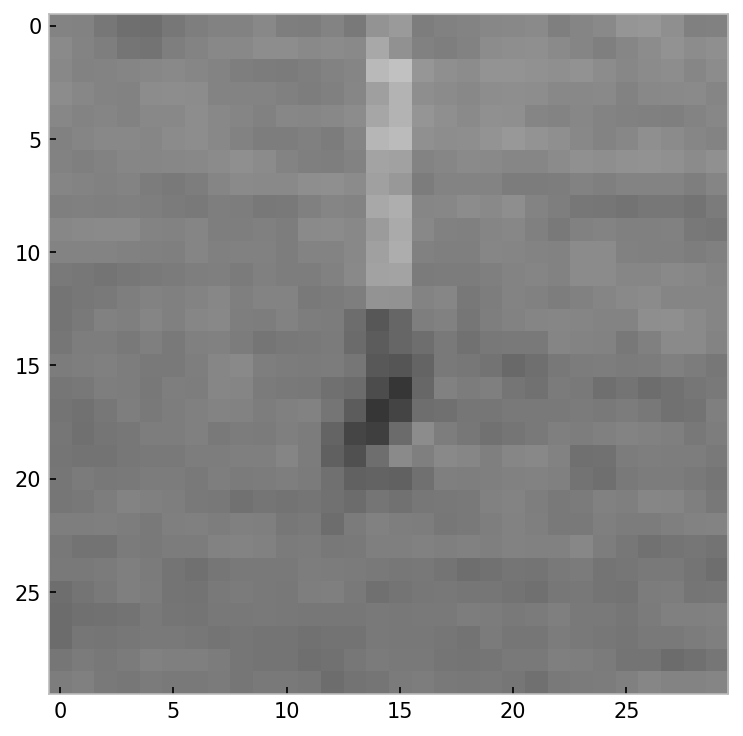

In [343]:
plt.imshow(img.numpy().squeeze(), cmap=plt.cm.gray, vmin=-2, vmax=2)
plt.grid(None)
plt.title(f"")

In [344]:
class UnaryDefectDataModule(pl.LightningDataModule):
    """DataModule for defects data."""

    def __init__(self,
                 train_defects: pd.DataFrame,
                 val_defects: pd.DataFrame,
                 test_defects: pd.DataFrame,
                 frame_dir: Union[str, pathlib.Path],
                 sample_dim: int = 120,
                 sample_num: Optional[int] = None,
                 resize: Optional[int] = None,
                 scaling: str = "range",
                 percentiles: list = [25, 75],
                 references: list = [-0.25, 0.25],
                 workers: int = 3,
                 batch_size: int = 64,
                 random_state: Optional[int] = None,
                 verbose: bool = False):

        super().__init__()

        self.train_defects = train_defects
        self.val_defects = val_defects
        self.test_defects = test_defects
        self.frame_dir = pathlib.Path(frame_dir)
        self.sample_dim = sample_dim
        self.sample_num = sample_num
        self.resize = resize
        self.scaling = scaling
        self.percentiles = percentiles
        self.references = references
        self.workers = workers
        self.batch_size = batch_size
        self.random_state = random_state
        self.verbose = verbose

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_ds = UnaryDefectsDataset(self.train_defects,
                                                frame_dir=self.frame_dir,
                                                sample_dim=self.sample_dim,
                                                sample_num=self.sample_num,
                                                resize=self.resize,
                                                scaling=self.scaling,
                                                percentiles=self.percentiles,
                                                references=self.references,
                                                tag="train",
                                                random_state=self.random_state,
                                                verbose=self.verbose)
            self.val_ds = UnaryDefectsDataset(self.val_defects,
                                              frame_dir=self.frame_dir,
                                              sample_dim=self.sample_dim,
                                              sample_num=self.sample_num,
                                              resize=self.resize,
                                              scaling=self.scaling,
                                              percentiles=self.percentiles,
                                              references=self.references,
                                              tag="val",
                                              random_state=self.random_state,
                                              verbose=self.verbose)

        if stage == "test" or stage is None:
            self.test_ds = UnaryDefectsDataset(self.test_defects,
                                               frame_dir=self.frame_dir,
                                               sample_dim=self.sample_dim,
                                               sample_num=self.sample_num,
                                               resize=self.resize,
                                               scaling=self.scaling,
                                               percentiles=self.percentiles,
                                               references=self.references,
                                               tag="test",
                                               random_state=self.random_state,
                                               verbose=self.verbose)
    
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, num_workers=self.workers)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, num_workers=self.workers)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=self.workers)

In [519]:
dm = UnaryDefectDataModule(target[target.frame.isin(TRAIN_FRAMES)],
                           target[target.frame.isin(VAL_FRAMES)],
                           target[target.frame.isin(TEST_FRAMES)],
                           frame_dir=DATA_DIR.joinpath("FRAMES"),
                           scaling="quantile",
                           resize=3,
                           percentiles=[25, 75],
                           references=[-0.05, 0.05],
                           sample_num=1000,
                           random_state=RS)
dm.setup()


  0%|          | 0/1000 [00:00<?, ?it/s]2023-12-17 06:11:10 localhost.localdomain train[18496] WARNING sample 2022.10.17/2_517.frame is outside the frame: (114:234, -3:117)

 10%|█         | 105/1000 [00:00<00:00, 1043.50it/s]2023-12-17 06:11:10 localhost.localdomain train[18496] WARNING sample 2022.07.21/1/0_523.frame is outside the frame: (-10:110, 795:915)

 23%|██▎       | 232/1000 [00:00<00:00, 1168.19it/s]2023-12-17 06:11:10 localhost.localdomain train[18496] WARNING sample 2023.09.07 13-09-28 78-23-04_1/1_824.frame is outside the frame: (-13:107, 713:833)

 61%|██████    | 607/1000 [00:00<00:00, 1205.18it/s]2023-12-17 06:11:10 localhost.localdomain train[18496] WARNING sample 2023.06.27 08-39-37 58-23-04_1/3_123.frame is outside the frame: (36:156, 846:966)

 73%|███████▎  | 728/1000 [00:00<00:00, 1174.53it/s]2023-12-17 06:11:10 localhost.localdomain train[18496] WARNING sample 2023.06.05/4_196.frame is outside the frame: (483:603, 271:391)

 85%|████████▍ | 846/1000 [00:00<00:

In [520]:
len(dm.train_ds), len(dm.val_ds), len(dm.test_ds)

(994, 993, 994)

In [521]:
imgs, labels = next(iter(dm.train_dataloader()))

In [522]:
classes.iloc[labels.argmax(axis=1).numpy()]

,colorcode,class,classname
0,66FF66AA,0,не дефект
0,66FF66AA,0,не дефект
0,66FF66AA,0,не дефект
0,66FF66AA,0,не дефект
0,66FF66AA,0,не дефект
...,...,...,...
0,66FF66AA,0,не дефект
9,880088FF,9,н.д. микровыступ
0,66FF66AA,0,не дефект
0,66FF66AA,0,не дефект


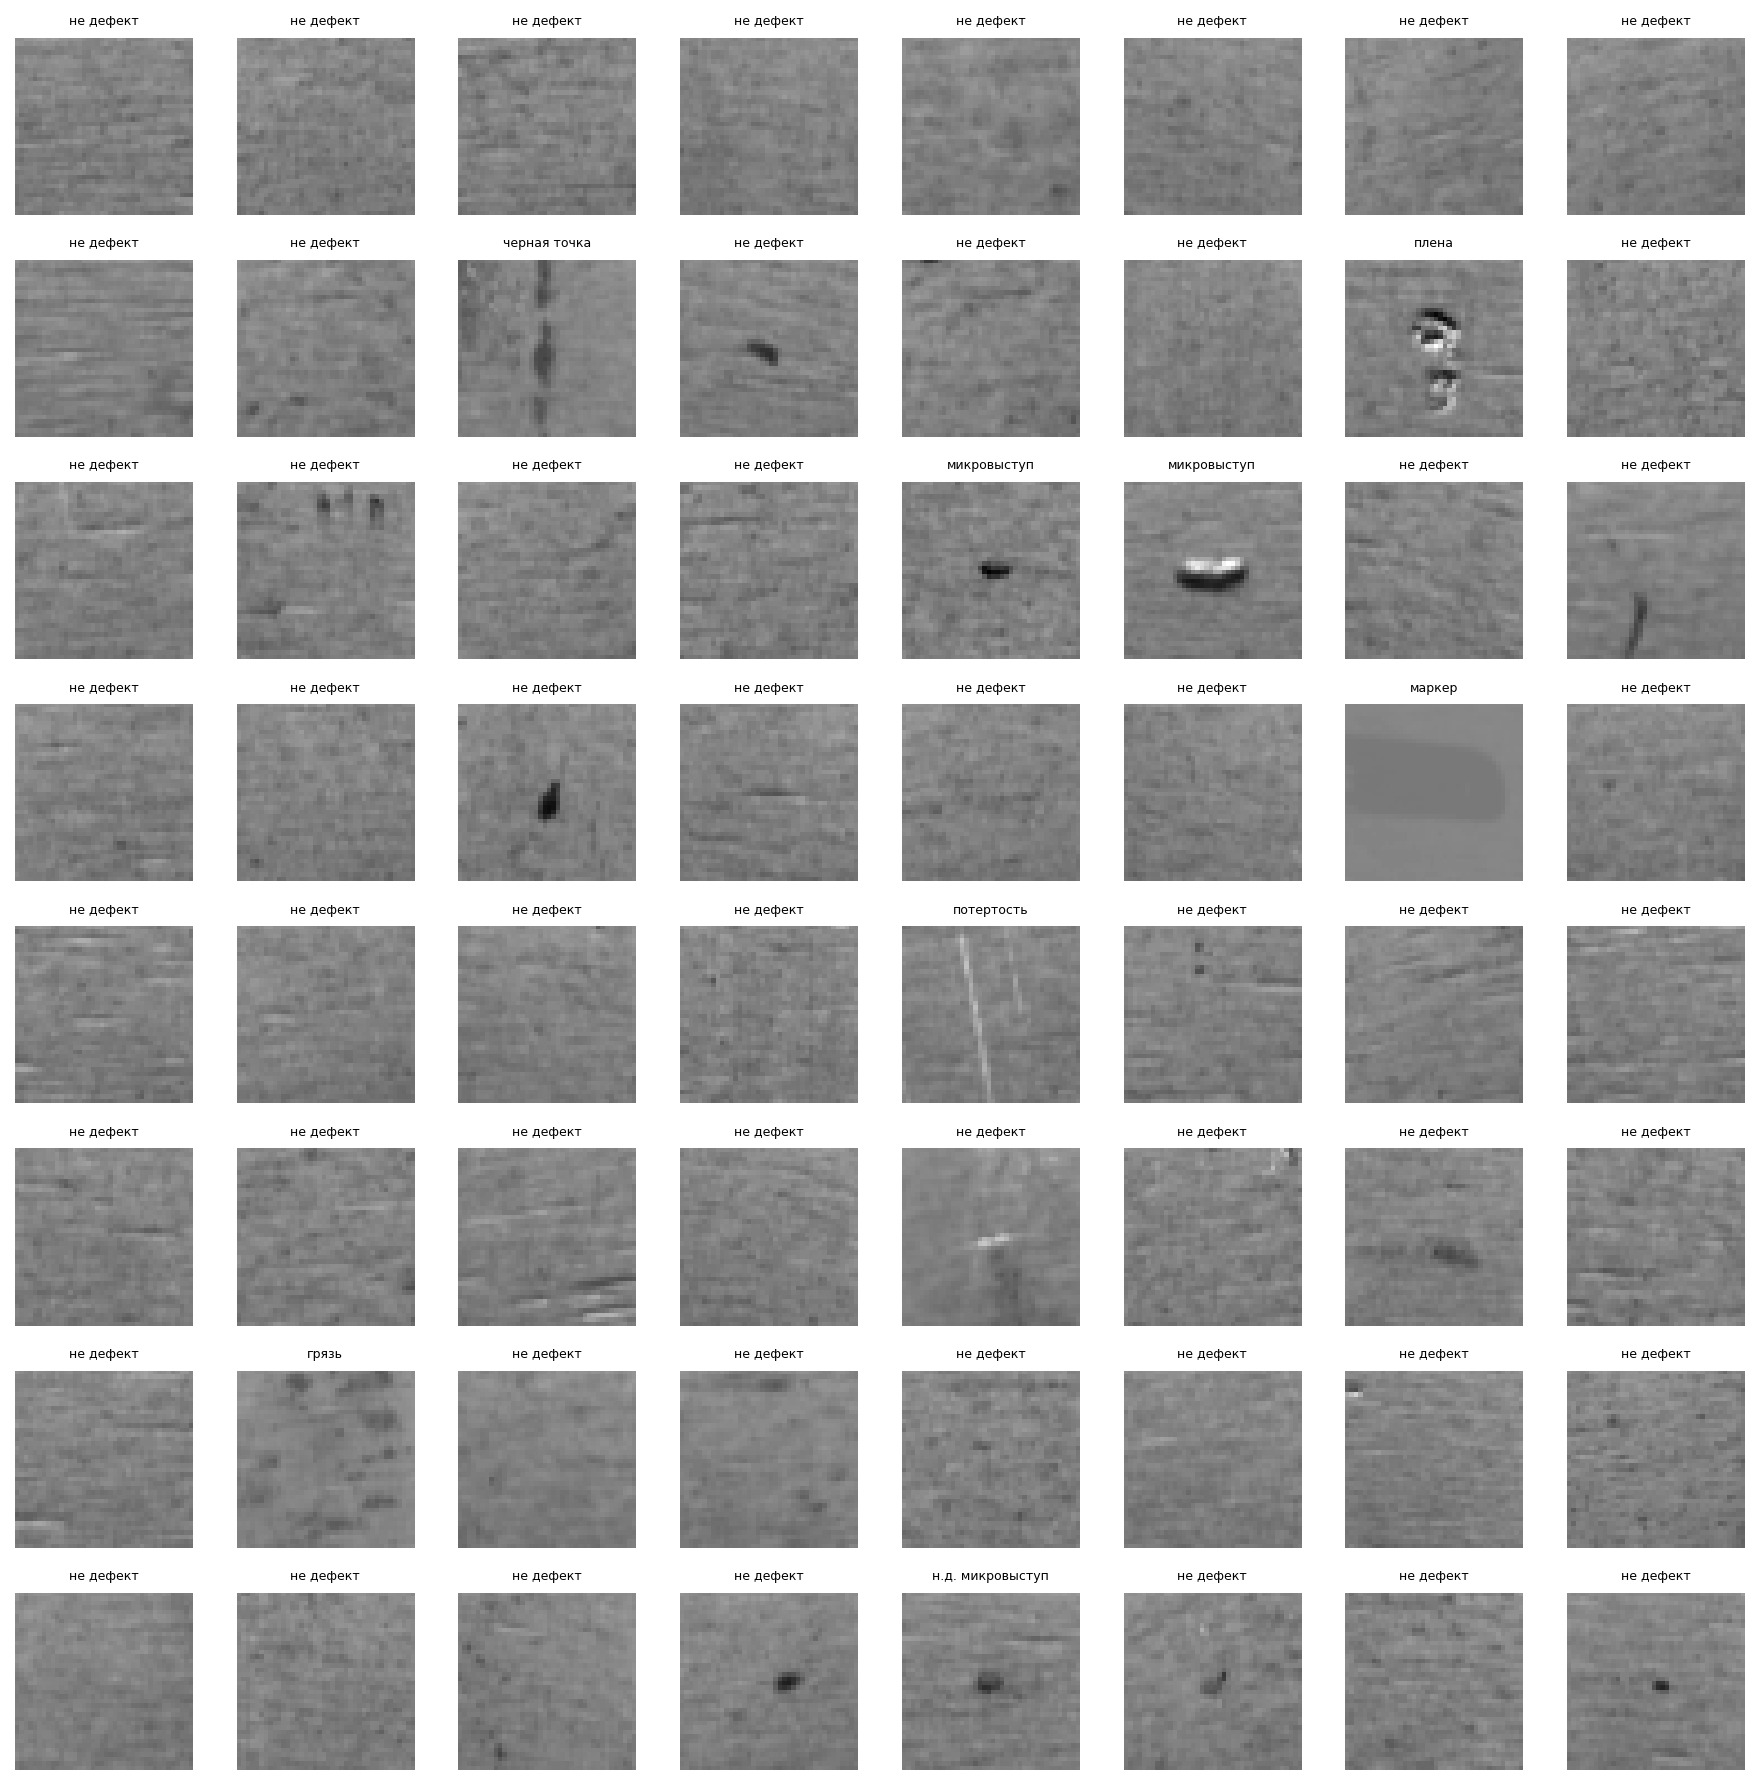

In [523]:
batch_labels = classes.iloc[labels.argmax(axis=1).numpy()]
batch = imgs.numpy().squeeze()

plt.figure(figsize=(12,12))

for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(batch[i], cmap=plt.cm.gray, vmin=-1, vmax=1)
    plt.grid(None)
    plt.xticks([])
    plt.yticks([])
    plt.gca().axis("off")
    plt.title(f"{batch_labels.iloc[i]['classname']}", fontsize=6)

plt.tight_layout()
plt.show()

# Базовая модель

In [336]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score

In [629]:
class UnaryDefectsModel(pl.LightningModule):
    """Convolutional model for surface defects detection."""
   
    def __init__(self,
                 input_channels: int = 1,
                 weight: Optional[list] = None,
                 lr: float = 1e-3):
        super().__init__()

        self.input_channels = input_channels
        self.weight = weight
        self.lr = lr

        self.pool = nn.MaxPool2d(2)
        self.conv_act = nn.ReLU()
        self.dropout = nn.Dropout2d(0.5)

        # 1st Conv2D module
        self.conv_11 = nn.Conv2d(in_channels=self.input_channels,
                                 out_channels=16,
                                 kernel_size=3,
                                 padding=4,
                                 padding_mode="replicate")
        self.bn_11 = nn.BatchNorm2d(16)
        self.conv_12 = nn.Conv2d(in_channels=16,
                                 out_channels=16,
                                 kernel_size=3,
                                 padding=4,
                                 padding_mode="replicate")
        self.bn_12 = nn.BatchNorm2d(16)

        # 2d Conv2D module
        self.conv_21 = nn.Conv2d(in_channels=16,
                                 out_channels=32,
                                 kernel_size=3,
                                 padding=4,
                                 padding_mode="replicate")
        self.bn_21 = nn.BatchNorm2d(32)
        self.conv_22 = nn.Conv2d(in_channels=32,
                                 out_channels=32,
                                 kernel_size=3,
                                 padding=4,
                                 padding_mode="replicate")
        self.bn_22 = nn.BatchNorm2d(32)

        # 3d Conv2D module
        self.conv_3 = nn.Conv2d(in_channels=32,
                                out_channels=64,
                                kernel_size=3,
                                padding=2,
                                padding_mode="replicate")
        self.bn_3 = nn.BatchNorm2d(64)

        # 4th Conv2D module
        self.conv_4 = nn.Conv2d(in_channels=64,
                                out_channels=64,
                                kernel_size=3,
                                padding=2,
                                padding_mode="replicate")

        # 5th Conv2D module
        self.conv_5 = nn.Conv2d(in_channels=64,
                                out_channels=128,
                                kernel_size=3,
                                padding=2,
                                padding_mode="replicate")

        # 6th Conv2D module
        self.conv_6 = nn.Conv2d(in_channels=128,
                                out_channels=256,
                                kernel_size=3,
                                padding=2,
                                padding_mode="replicate")

        
        # Fully-connected
        self.fc_1 = nn.Linear(in_features=256, out_features=128)
        self.act_1 = nn.ReLU()
        self.fc_2 = nn.Linear(in_features=128, out_features=32)
        self.act_2 = nn.ReLU()
        self.fc_3 = nn.Linear(in_features=32, out_features=14)

        
        self.loss = nn.CrossEntropyLoss(torch.Tensor(self.weight) if weight else None)

    def forward(self, x, y=None):

        # Make a tensor 4D to process a single sample
        if len(x.shape) < 4:
            x = x.unsqueeze(0)

        # 1st Conv2D
        x = self.conv_11(x)
        x = self.conv_act(x)
        x = self.conv_12(x)
        x = self.conv_act(x)
        x = self.pool(x)
        x = self.dropout(x)

        # 2d Conv2D
        x = self.conv_21(x)
        x = self.conv_act(x)
        x = self.conv_22(x)
        x = self.conv_act(x)
        x = self.pool(x)
        x = self.dropout(x)

        # 3d Conv2D
        x = self.conv_3(x)
        x = self.conv_act(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.dropout(x)
        x = self.conv_4(x)
        x = self.conv_act(x)
        x = self.conv_5(x)
        x = self.conv_act(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.conv_6(x)
        x = self.conv_act(x)
        x = x.amax(dim=[2,3])

        # FC
        x = self.fc_1(x)
        x = self.act_1(x)
        x = self.fc_2(x)
        x = self.act_2(x)
        x = self.fc_3(x)

        return x

    def step(self, batch, batch_idx, tag):
        """Make a single-batch pass through the net collecting the loss."""

        imgs, labels = batch

        # Pushing through the network
        out = self(imgs)

        # Logging F1 and accuracy for the target
        target = labels.argmax(axis=-1)
        predicted = out.argmax(axis=-1)

        self.log(f"{tag}_f1",
                 f1_score(target.detach().numpy(), predicted.detach().numpy(), average="weighted"),
                 prog_bar=True)

        self.log(f"{tag}_acc",
                 accuracy_score(target.detach().numpy(), predicted.detach().numpy()),
                 prog_bar=True)

        loss = self.loss(out, target)

        self.log(f"{tag}_loss", loss, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx, "train")
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx, "val")
        return loss

    def test_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx, "test")
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [630]:
model = UnaryDefectsModel(weight=[0.2] + [1] * 13)

Батч:

In [631]:
model(imgs).shape

torch.Size([64, 14])

Один семпл:

In [632]:
model(img).shape

torch.Size([1, 14])

# Тренировка модели

In [633]:
from pytorch_lightning import loggers as pl_loggers

In [658]:
LOG_DIR = pathlib.Path("./")
EXPERIMENT = "unary_0.1a"
TAGS = ["unary", "atomic"]
VERSION = "0.21a"

tb_logger = pl_loggers.TensorBoardLogger(name=EXPERIMENT,
                                         version=VERSION,
                                         save_dir=LOG_DIR.joinpath("tb_logs"))

early_stopping = pl.callbacks.EarlyStopping('val_f1', patience=15)
checkpoints = pl.callbacks.ModelCheckpoint(dirpath=LOG_DIR.joinpath('checkpoints'),
                                           filename=(f"unary-{VERSION}"
                                                     + "_{epoch:02d}-{val_f1:.4f}-{val_loss:.4f}"),
                                           save_top_k=1,
                                           verbose=True,
                                           monitor='val_f1',
                                           mode='max')

/home/traveller/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Checkpoint directory checkpoints exists and is not empty.
  warnings.warn(*args, **kwargs)


In [659]:
dm = UnaryDefectDataModule(target[target.frame.isin(TRAIN_FRAMES)],
                           target[target.frame.isin(VAL_FRAMES)],
                           target[target.frame.isin(TEST_FRAMES)],
                           frame_dir=DATA_DIR.joinpath("FRAMES"),
                           scaling="quantile",
                           percentiles=[25, 75],
                           references=[-0.25, 0.25],
                           resize=4,
                           sample_num=10000,
                           random_state=RS)
model = UnaryDefectsModel()

In [660]:
model.load_state_dict(torch.load(LOG_DIR.joinpath("checkpoints", "unary-0.20a_epoch=10-val_f1=0.8728-val_loss=0.3368.ckpt"))["state_dict"])

<All keys matched successfully>

In [661]:
trainer = pl.Trainer(max_epochs=50, callbacks=[early_stopping, checkpoints], logger=tb_logger)
trainer.fit(model, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  0%|          | 0/10000 [00:00<?, ?it/s]2023-12-17 07:48:07 localhost.localdomain train[18496] WARNING sample 2022.10.17/2_517.frame is outside the frame: (114:234, -3:117)

  1%|▏         | 133/10000 [00:00<00:23, 418.72it/s]2023-12-17 07:48:07 localhost.localdomain train[18496] WARNING sample 2022.07.21/1/0_523.frame is outside the frame: (-10:110, 795:915)

  3%|▎         | 319/10000 [00:00<00:21, 455.87it/s]2023-12-17 07:48:07 localhost.localdomain train[18496] WARNING sample 2023.09.07 13-09-28 78-23-04_1/1_824.frame is outside the frame: (-13:107, 713:833)

  6%|▌         | 600/10000 [00:01<00:21, 442.59it/s]2023-12-17 07:48:08 localhost.localdomain train[18496] WARNING sample 2023.06.27 08-39-37 58-23-04_1/3_123.frame is outside the frame: (36:156, 846:966)

  7%|▋         | 740/10000 [00:01<00:20, 444.08it/s]2023-12-17 07:48:08 localhost.localdomain train[18496] WARNING sample 2023.06.05/4_196.frame is

 48%|████▊     | 4757/10000 [00:08<00:07, 668.38it/s]2023-12-17 07:48:16 localhost.localdomain train[18496] WARNING sample 2021.08.30/1_079.frame is outside the frame: (9:129, -4:116)

 51%|█████     | 5080/10000 [00:09<00:08, 614.85it/s]2023-12-17 07:48:16 localhost.localdomain train[18496] WARNING sample 2023.04.18/5_152.frame is outside the frame: (-2:118, 582:702)

 51%|█████▏    | 5142/10000 [00:09<00:07, 608.40it/s]2023-12-17 07:48:16 localhost.localdomain train[18496] WARNING sample 2023.07.21/1_523.frame is outside the frame: (406:526, 858:978)

 53%|█████▎    | 5343/10000 [00:09<00:07, 635.31it/s]2023-12-17 07:48:17 localhost.localdomain train[18496] WARNING sample 2023.09.05 78-23-04_1/2_279.frame is outside the frame: (494:614, 752:872)
2023-12-17 07:48:17 localhost.localdomain train[18496] WARNING sample 2023.04.18/4_174.frame is outside the frame: (281:401, -5:115)

 54%|█████▍    | 5408/10000 [00:10<00:07, 638.19it/s]2023-12-17 07:48:17 localhost.localdomain train[18496] 


 94%|█████████▍| 9433/10000 [00:15<00:00, 736.47it/s]2023-12-17 07:48:22 localhost.localdomain train[18496] WARNING sample 2023.09.05 78-23-04_1/5_805.frame is outside the frame: (-3:117, 582:702)
2023-12-17 07:48:22 localhost.localdomain train[18496] WARNING sample 2023.04.11 брак/4_586.frame is outside the frame: (493:613, 614:734)

 97%|█████████▋| 9661/10000 [00:16<00:00, 728.16it/s]2023-12-17 07:48:23 localhost.localdomain train[18496] WARNING sample 2022.07.21/1/0_523.frame is outside the frame: (-4:116, 637:757)

 98%|█████████▊| 9813/10000 [00:16<00:00, 741.25it/s]2023-12-17 07:48:23 localhost.localdomain train[18496] WARNING sample 2023.09.07 13-09-28 78-23-04_1/5_425.frame is outside the frame: (-4:116, 287:407)
2023-12-17 07:48:23 localhost.localdomain train[18496] WARNING sample 2023.04.11 брак/4_788.frame is outside the frame: (504:624, 573:693)

100%|██████████| 10000/10000 [00:16<00:00, 600.78it/s]
2023-12-17 07:48:23 localhost.localdomain val[18496] WARNING requested 1

 40%|████      | 4007/9950 [00:06<00:08, 674.17it/s]2023-12-17 07:48:30 localhost.localdomain val[18496] WARNING sample 2022.07.21/0/4_361.frame is outside the frame: (-39:81, 89:209)
2023-12-17 07:48:30 localhost.localdomain val[18496] WARNING sample 2023.08.07/2_776.frame is outside the frame: (-12:108, 719:839)

 42%|████▏     | 4147/9950 [00:07<00:08, 682.76it/s]2023-12-17 07:48:30 localhost.localdomain val[18496] WARNING sample 2023.04.18/0/2_891.frame is outside the frame: (14:134, -8:112)

 45%|████▍     | 4438/9950 [00:07<00:07, 705.26it/s]2023-12-17 07:48:31 localhost.localdomain val[18496] WARNING sample 2023.06.27 08-39-37 58-23-04_1/1_749.frame is outside the frame: (489:609, 512:632)
2023-12-17 07:48:31 localhost.localdomain val[18496] WARNING sample 2023.10.25/5_428.frame is outside the frame: (-6:114, 502:622)

 45%|████▌     | 4509/9950 [00:07<00:07, 697.58it/s]2023-12-17 07:48:31 localhost.localdomain val[18496] WARNING sample 2023.08.08 71-23-07_1/4_735.frame is outsi


 95%|█████████▌| 9465/9950 [00:14<00:00, 783.24it/s]2023-12-17 07:48:37 localhost.localdomain val[18496] WARNING sample 2023.07.12/4_605.frame is outside the frame: (-38:82, 136:256)

 96%|█████████▌| 9544/9950 [00:14<00:00, 784.80it/s]2023-12-17 07:48:38 localhost.localdomain val[18496] WARNING sample 2023.10.10 804-23-04_1/5_615.frame is outside the frame: (502:622, 728:848)

 97%|█████████▋| 9623/9950 [00:14<00:00, 775.53it/s]2023-12-17 07:48:38 localhost.localdomain val[18496] WARNING sample 2023.10.25/2_324.frame is outside the frame: (-1:119, 200:320)
2023-12-17 07:48:38 localhost.localdomain val[18496] WARNING sample 2023.10.25/1_477.frame is outside the frame: (-1:119, 707:827)
2023-12-17 07:48:38 localhost.localdomain val[18496] WARNING sample 2023.06.16 09-22-15 57-23-06_1/4_750.frame is outside the frame: (103:223, 867:987)

100%|██████████| 9950/9950 [00:14<00:00, 672.80it/s]

   | Name     | Type             | Params
-----------------------------------------------
0  | po

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 155: val_f1 reached 0.86940 (best 0.86940), saving model to "/home/traveller/SWProj/Challenges/AtomicHack/notebooks/checkpoints/unary-0.21a_epoch=00-val_f1=0.8694-val_loss=0.3432.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 311: val_f1 reached 0.87082 (best 0.87082), saving model to "/home/traveller/SWProj/Challenges/AtomicHack/notebooks/checkpoints/unary-0.21a_epoch=01-val_f1=0.8708-val_loss=0.3363.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 467: val_f1 reached 0.87221 (best 0.87221), saving model to "/home/traveller/SWProj/Challenges/AtomicHack/notebooks/checkpoints/unary-0.21a_epoch=02-val_f1=0.8722-val_loss=0.3441.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 623: val_f1 was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 779: val_f1 was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 935: val_f1 was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 1091: val_f1 was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 1247: val_f1 reached 0.87491 (best 0.87491), saving model to "/home/traveller/SWProj/Challenges/AtomicHack/notebooks/checkpoints/unary-0.21a_epoch=07-val_f1=0.8749-val_loss=0.3541.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 1403: val_f1 reached 0.87887 (best 0.87887), saving model to "/home/traveller/SWProj/Challenges/AtomicHack/notebooks/checkpoints/unary-0.21a_epoch=08-val_f1=0.8789-val_loss=0.3670.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 1559: val_f1 was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 1715: val_f1 reached 0.88142 (best 0.88142), saving model to "/home/traveller/SWProj/Challenges/AtomicHack/notebooks/checkpoints/unary-0.21a_epoch=10-val_f1=0.8814-val_loss=0.3598.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 1871: val_f1 was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 2027: val_f1 was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 2183: val_f1 was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 2339: val_f1 reached 0.88446 (best 0.88446), saving model to "/home/traveller/SWProj/Challenges/AtomicHack/notebooks/checkpoints/unary-0.21a_epoch=14-val_f1=0.8845-val_loss=0.4018.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 2495: val_f1 was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 2651: val_f1 was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 2807: val_f1 was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 2963: val_f1 was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 3119: val_f1 was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 3275: val_f1 was not in top 1


In [662]:
model.load_state_dict(torch.load(LOG_DIR.joinpath("checkpoints", "unary-0.21a_epoch=14-val_f1=0.8845-val_loss=0.4018.ckpt"))["state_dict"])

<All keys matched successfully>

In [663]:
dm.setup(stage="test")

2023-12-17 08:09:37 localhost.localdomain test[18496] WARNING requested 10000 samples from 6495 defects, using the smaller one

  4%|▍         | 278/6495 [00:00<00:08, 711.27it/s]2023-12-17 08:09:37 localhost.localdomain test[18496] WARNING sample 2023.09.05 83-23-04_1/5_279.frame is outside the frame: (-5:115, 369:489)

  7%|▋         | 424/6495 [00:00<00:08, 716.36it/s]2023-12-17 08:09:38 localhost.localdomain test[18496] WARNING sample 2023.04.11 брак/1_765.frame is outside the frame: (500:620, 493:613)

  8%|▊         | 496/6495 [00:00<00:08, 696.71it/s]2023-12-17 08:09:38 localhost.localdomain test[18496] WARNING sample 2023.01.09/T52_dist_1_frame_2.frame is outside the frame: (502:622, 398:518)

  9%|▊         | 566/6495 [00:00<00:08, 684.64it/s]2023-12-17 08:09:38 localhost.localdomain test[18496] WARNING sample 2023.06.21 57-23-05_1/5_596.frame is outside the frame: (-9:111, 407:527)

 13%|█▎        | 846/6495 [00:01<00:08, 689.55it/s]2023-12-17 08:09:38 localhost.localdomain t


 69%|██████▊   | 4452/6495 [00:06<00:02, 684.52it/s]2023-12-17 08:09:44 localhost.localdomain test[18496] WARNING sample 2023.06.15/4_426.frame is outside the frame: (-17:103, 685:805)

 70%|██████▉   | 4522/6495 [00:06<00:02, 684.83it/s]2023-12-17 08:09:44 localhost.localdomain test[18496] WARNING sample 2023.05.16/4_633.frame is outside the frame: (-11:109, 729:849)

 75%|███████▌  | 4893/6495 [00:07<00:02, 655.63it/s]2023-12-17 08:09:44 localhost.localdomain test[18496] WARNING sample 2023.04.18/2_527.frame is outside the frame: (166:286, 846:966)

 76%|███████▋  | 4960/6495 [00:07<00:02, 589.04it/s]2023-12-17 08:09:44 localhost.localdomain test[18496] WARNING sample 2023.09.07 13-09-28 78-23-04_1/0/5_335.frame is outside the frame: (-11:109, 525:645)

 77%|███████▋  | 5021/6495 [00:07<00:02, 555.67it/s]2023-12-17 08:09:45 localhost.localdomain test[18496] WARNING sample 2023.04.11 брак/1_765.frame is outside the frame: (494:614, 278:398)

 78%|███████▊  | 5081/6495 [00:07<00:02, 5

In [664]:
trainer.test()

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8781206607818604,
 'test_f1': 0.885076642036438,
 'test_loss': 0.40989232063293457}
--------------------------------------------------------------------------------


[{'test_f1': 0.885076642036438,
  'test_acc': 0.8781206607818604,
  'test_loss': 0.40989232063293457}]

# Примеры распознавания

In [645]:
test_samples = dm.test_ds.samples[dm.test_ds.samples.valid]

Для референса: случайный классификатор.

In [646]:
random_labels = test_samples.label.sample(len(test_samples), replace=True)
random_labels

18393    0
20858    1
16716    0
17802    1
33458    9
        ..
16223    1
4672     0
2735     0
8676     1
5972     0
Name: label, Length: 6449, dtype: int64

In [647]:
f1_score(test_samples.label.values, random_labels.values, average="weighted")

0.5394579001307219

In [648]:
accuracy_score(test_samples.label.values, random_labels.values)

0.5393084199100636

Для референса: всегда прогнозируем `нет дефекта`.

In [649]:
f1_score(test_samples.label.values, np.zeros(len(test_samples)), average="weighted")

0.6054035999843331

In [650]:
accuracy_score(test_samples.label.values, np.zeros(len(test_samples)))

0.7219723988215228

In [665]:
test_labels = []

for idx in range(len(dm.test_ds)):
    sample, label = dm.test_ds[idx]
    pred = model(sample).argmax(axis=1).item()
    actual = label.argmax().item()
    test_labels.append([actual, pred])

test_labels = pd.DataFrame(test_labels, columns=["actual", "predicted"])

In [697]:
classes.replace({"плена": "пленка"}, inplace=True)

In [705]:
test_labels = (test_labels
               .merge(classes[["class", "classname"]], how="left", left_on="actual", right_on="class", suffixes=["", "_actual"])
               .merge(classes[["class", "classname"]], how="left", left_on="predicted", right_on="class", suffixes=["", "_predicted"]))

In [707]:
classification_report?

In [708]:
print(classification_report(test_labels.actual, test_labels.predicted, target_names=classes.classname))

                    precision    recall  f1-score   support

         не дефект       0.98      0.95      0.96      4656
        потертость       0.85      0.75      0.79       783
      черная точка       0.67      0.60      0.63        47
            пленка       0.26      0.50      0.34        36
            маркер       0.77      0.77      0.77       175
             грязь       0.52      0.69      0.60       250
             накол       0.50      0.95      0.66        44
        н.д. накол       0.30      0.19      0.24        31
       микровыступ       0.46      0.44      0.45       104
  н.д. микровыступ       0.55      0.81      0.65       190
           вмятина       0.75      0.38      0.50         8
   мех.повреждение       0.45      0.26      0.33        78
             риска       0.86      0.32      0.46        19
царапина с волчком       0.30      0.75      0.43        28

          accuracy                           0.88      6449
         macro avg       0.59      0.6

In [709]:
test_labels.classname.value_counts()

classname
не дефект             4656
потертость             783
грязь                  250
н.д. микровыступ       190
маркер                 175
микровыступ            104
мех.повреждение         78
черная точка            47
накол                   44
пленка                  36
н.д. накол              31
царапина с волчком      28
риска                   19
вмятина                  8
Name: count, dtype: int64

In [710]:
cm = pd.DataFrame(confusion_matrix(test_labels.actual, test_labels.predicted, normalize="true"),
                  columns=classes.classname,
                  index=classes.classname)

In [711]:
order = np.argsort(np.diag(cm.values))[::-1]

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5]),
 [Text(0, 0.5, 'накол'),
  Text(0, 1.5, 'не дефект'),
  Text(0, 2.5, 'н.д. микровыступ'),
  Text(0, 3.5, 'маркер'),
  Text(0, 4.5, 'царапина с волчком'),
  Text(0, 5.5, 'потертость'),
  Text(0, 6.5, 'грязь'),
  Text(0, 7.5, 'черная точка'),
  Text(0, 8.5, 'пленка'),
  Text(0, 9.5, 'микровыступ'),
  Text(0, 10.5, 'вмятина'),
  Text(0, 11.5, 'риска'),
  Text(0, 12.5, 'мех.повреждение'),
  Text(0, 13.5, 'н.д. накол')])

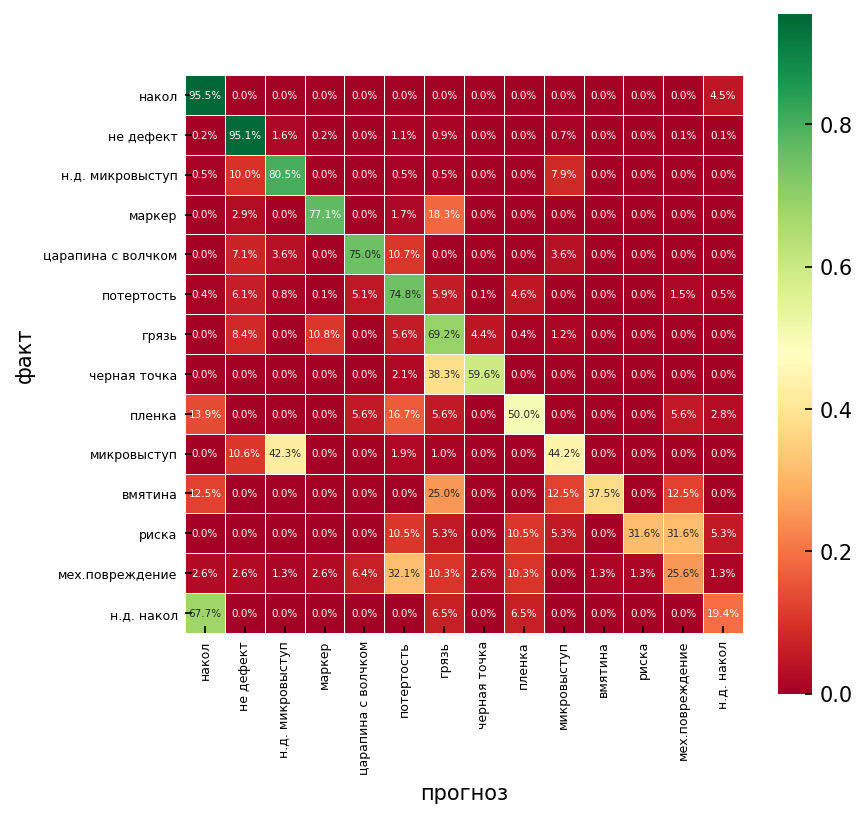

In [717]:
sns.heatmap(cm.iloc[order, order], annot=True, fmt=".1%", linewidths=.25, square=True, annot_kws={"fontsize": 5}, cmap=plt.cm.RdYlGn)
plt.xlabel("прогноз", fontsize=10)
plt.ylabel("факт", fontsize=10)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

In [713]:
print(classification_report(test_labels.actual!=0, test_labels.predicted!=0, target_names=["не дефект", "дефект"]))

              precision    recall  f1-score   support

   не дефект       0.98      0.95      0.96      4656
      дефект       0.88      0.94      0.91      1793

    accuracy                           0.95      6449
   macro avg       0.93      0.95      0.94      6449
weighted avg       0.95      0.95      0.95      6449



In [719]:
print(model)

UnaryDefectsModel(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_act): ReLU()
  (dropout): Dropout2d(p=0.5, inplace=False)
  (conv_11): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), padding_mode=replicate)
  (bn_11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), padding_mode=replicate)
  (bn_12): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_21): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), padding_mode=replicate)
  (bn_21): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_22): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), padding_mode=replicate)
  (bn_22): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(